In [1]:
!sudo apt-get install -y xvfb ffmpeg
!pip install gym
!pip install 'imageio==2.4.0'
!pip install matplotlib
!pip install PILLOW
!pip install tf-agents[reverb]
!pip install pybullet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 2s (382 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected pack

In [2]:
import base64
import imageio
import IPython
import matplotlib.pyplot as plt
import os
import reverb
import tempfile
import PIL.Image
import tensorflow as tf

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.environments import suite_pybullet
from tf_agents.experimental.train import actor
from tf_agents.experimental.train import learner
from tf_agents.experimental.train import triggers
from tf_agents.experimental.train.utils import spec_utils
from tf_agents.experimental.train.utils import strategy_utils
from tf_agents.experimental.train.utils import train_utils
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils

tempdir = tempfile.gettempdir()

In [3]:
env_name = "MinitaurBulletEnv-v0" # @param {type:"string"}

# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (256, 256)
critic_joint_fc_layer_params = (256, 256)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}

policy_save_interval = 5000 # @param {type:"integer"}

current_dir=/usr/local/lib/python3.6/dist-packages/pybullet_envs/bullet
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


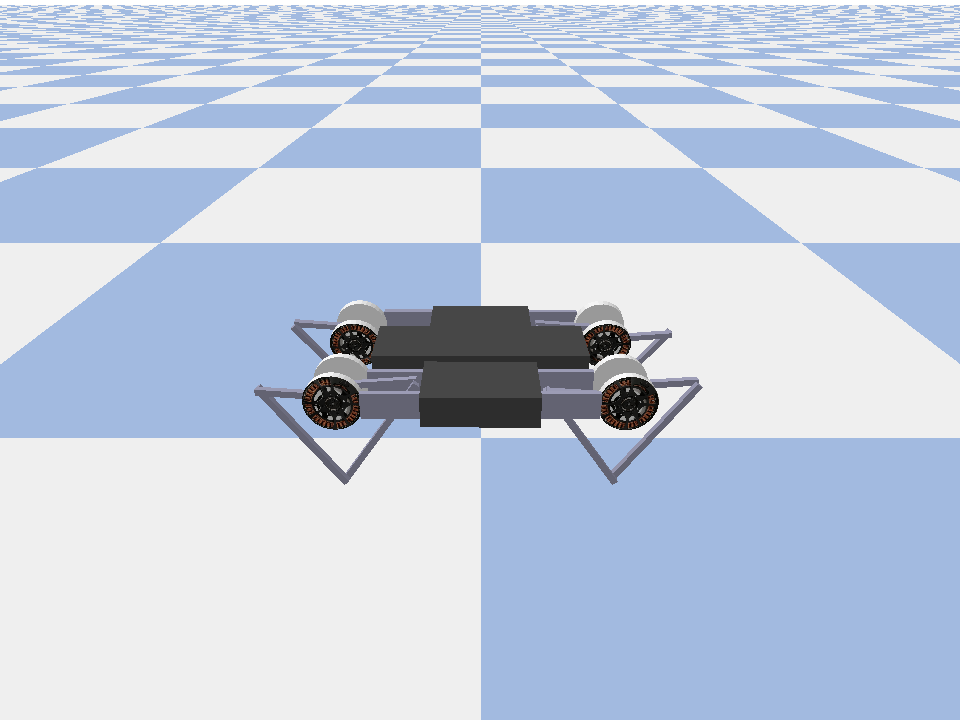

In [4]:
env = suite_pybullet.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [5]:
print('Observation Spec:')
print(env.time_step_spec().observation)
print('Action Spec:')
print(env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(28,), dtype=dtype('float32'), name='observation', minimum=[  -3.1515927   -3.1515927   -3.1515927   -3.1515927   -3.1515927
   -3.1515927   -3.1515927   -3.1515927 -167.72488   -167.72488
 -167.72488   -167.72488   -167.72488   -167.72488   -167.72488
 -167.72488     -5.71        -5.71        -5.71        -5.71
   -5.71        -5.71        -5.71        -5.71        -1.01
   -1.01        -1.01        -1.01     ], maximum=[  3.1515927   3.1515927   3.1515927   3.1515927   3.1515927   3.1515927
   3.1515927   3.1515927 167.72488   167.72488   167.72488   167.72488
 167.72488   167.72488   167.72488   167.72488     5.71        5.71
   5.71        5.71        5.71        5.71        5.71        5.71
   1.01        1.01        1.01        1.01     ])
Action Spec:
BoundedArraySpec(shape=(8,), dtype=dtype('float32'), name='action', minimum=-1.0, maximum=1.0)


In [6]:
collect_env = suite_pybullet.load(env_name)
eval_env = suite_pybullet.load(env_name)

urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data
urdf_root=/usr/local/lib/python3.6/dist-packages/pybullet_data


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [7]:
use_gpu = True #@param {type:"boolean"}

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
observation_spec, action_spec, time_step_spec = (
      spec_utils.get_tensor_specs(collect_env))

with strategy.scope():
  critic_net = critic_network.CriticNetwork(
        (observation_spec, action_spec),
        observation_fc_layer_params=None,
        action_fc_layer_params=None,
        joint_fc_layer_params=critic_joint_fc_layer_params,
        kernel_initializer='glorot_uniform',
        last_kernel_initializer='glorot_uniform')

In [9]:
with strategy.scope():
  actor_net = actor_distribution_network.ActorDistributionNetwork(
      observation_spec,
      action_spec,
      fc_layer_params=actor_fc_layer_params,
      continuous_projection_net=(
          tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [10]:
with strategy.scope():
  train_step = train_utils.create_train_step()

  tf_agent = sac_agent.SacAgent(
        time_step_spec,
        action_spec,
        actor_network=actor_net,
        critic_network=critic_net,
        actor_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=actor_learning_rate),
        critic_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=critic_learning_rate),
        alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
            learning_rate=alpha_learning_rate),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        td_errors_loss_fn=tf.math.squared_difference,
        gamma=gamma,
        reward_scale_factor=reward_scale_factor,
        train_step_counter=train_step)

  tf_agent.initialize()

In [11]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

In [12]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [13]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [14]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [15]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [16]:
random_policy = random_py_policy.RandomPyPolicy(
  collect_env.time_step_spec(), collect_env.action_spec())

In [17]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [18]:
initial_collect_actor = actor.Actor(
  collect_env,
  random_policy,
  train_step,
  steps_per_run=initial_collect_steps,
  observers=[rb_observer])
initial_collect_actor.run()

In [19]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
  collect_env,
  collect_policy,
  train_step,
  steps_per_run=1,
  metrics=actor.collect_metrics(10),
  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
  observers=[rb_observer, env_step_metric])

In [20]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

In [21]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


In [22]:
def get_eval_metrics():
  eval_actor.run()
  results = {}
  for metric in eval_actor.metrics:
    results[metric.name] = metric.result()
  return results

metrics = get_eval_metrics()

In [23]:
def log_eval_metrics(step, metrics):
  eval_results = (', ').join(
      '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
  print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = -0.069344, AverageEpisodeLength = 69.449997


In [24]:
try:
  %%time
except:
  pass

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
  # Training.
  collect_actor.run()
  loss_info = agent_learner.run(iterations=1)

  # Evaluating.
  step = agent_learner.train_step_numpy

  if eval_interval and step % eval_interval == 0:
    metrics = get_eval_metrics()
    log_eval_metrics(step, metrics)
    returns.append(metrics["AverageReturn"])

  if log_interval and step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

rb_observer.close()
reverb_server.stop()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
step = 5000: loss = -56.29584503173828
step = 10000: AverageReturn = -0.253277, AverageEpisodeLength = 115.150002
step = 10000: loss = -61.818077087402344
step = 15000: loss = -35.772247314453125
step = 20000: AverageReturn = -0.509222, AverageEpisodeLength = 189.399994
step = 20000: loss = -23.24066925048828
step = 25000: loss = -14.768136024475098
step = 30000: AverageReturn = -0.421942, AverageEpisodeLength = 202.850006
step = 30000: loss = -10.493082046508789
step = 35000: loss = -3.893254280090332
step = 40000: AverageReturn = -1.438437, AverageEpisodeLength = 443.549988
step = 40000: loss = -3.45211124420166
step = 45000: loss = -0.7804979085922241
step = 50000: AverageReturn = -1.504226, AverageEpisodeLength = 475.100006
step = 50000: loss = -0.8243061304092407
step = 55000: loss = -0.33377811312675476
step = 60000: AverageReturn = -1.247169, AverageEpisodeLength = 593.500000
step = 60000: loss = -1.8550291061401367

(-1.5984818503260612, 0.4751553997397423)

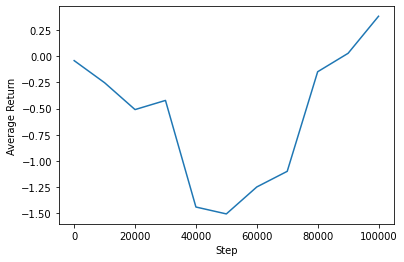

In [25]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()